### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
import joblib
pd.set_option('display.max_columns', None)

### 2. Load cleaned data

In [2]:
df = pd.read_csv(r'D:\T-100 REFRENCE\QUERY\Project Files\tmff_clean_name_view.csv')
df.shape

(3020205, 23)

In [3]:
df.duplicated().sum()

np.int64(0)

In [4]:
# df.drop_duplicates(inplace=True)

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.head()

,passengers,distance,airline_name,airline_code,carrierregion,origin_airport_name,origin_airport_code,origin_city_name,originstate,destination_airport_name,destination_airport_code,dest_city_name,deststate,distancegroup,serviceclass,year,month,quarter,average_fare_usd,inflation_adjusted_fare_usd,total_consumption_in_million_gallons,total_cost_in_million_dollars,total_cost_per_gallon_in_dollars
0,193,330,Great Lakes Airlines,ZK,Domestic,Worland Municipal,WRL,Worland,Wyoming,Denver International,DEN,Denver,Colorado,Less Than 500 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,598.000000,836.787423,1282.5,4097.7,3.2
1,212,82,Alaska Airlines Inc.,AS,Domestic,Wrangell Airport,WRG,Wrangell,Alaska,Ketchikan International,KTN,Ketchikan,Alaska,Less Than 500 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,429.207692,600.594647,1282.5,4097.7,3.2
2,190,756,Alaska Airlines Inc.,AS,Domestic,Wrangell Airport,WRG,Wrangell,Alaska,Seattle/Tacoma International,SEA,Seattle,Washington,500-999 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,429.207692,600.594647,1282.5,4097.7,3.2
3,127,1092,Alaska Airlines Inc.,AS,Domestic,Yakutat Airport,YAK,Yakutat,Alaska,Seattle/Tacoma International,SEA,Seattle,Washington,1000-1499 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,359.164179,502.582053,1282.5,4097.7,3.2
4,11,213,Alaska Airlines Inc.,AS,Domestic,Yakutat Airport,YAK,Yakutat,Alaska,Merle K Mudhole Smith,CDV,Cordova,Alaska,Less Than 500 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,359.164179,502.582053,1282.5,4097.7,3.2


In [7]:
df.drop(['inflation_adjusted_fare_usd', 'total_cost_per_gallon_in_dollars'], axis=1, inplace=True)

In [8]:
corr = df.corr(numeric_only = True)
corr

,passengers,distance,year,month,quarter,average_fare_usd,total_consumption_in_million_gallons,total_cost_in_million_dollars
passengers,1.000000,-0.017940,-0.002241,0.009817,0.010869,-0.104947,0.050139,0.006361
distance,-0.017940,1.000000,0.026510,0.001349,0.000674,-0.221890,0.016587,0.003499
year,-0.002241,0.026510,1.000000,-0.002615,-0.002979,0.062081,-0.003508,0.492073
month,0.009817,0.001349,-0.002615,1.000000,0.971847,-0.006483,0.125361,0.085226
quarter,0.010869,0.000674,-0.002979,0.971847,1.000000,-0.006631,0.129199,0.086298
average_fare_usd,-0.104947,-0.221890,0.062081,-0.006483,-0.006631,1.000000,0.097013,0.188069
total_consumption_in_million_gallons,0.050139,0.016587,-0.003508,0.125361,0.129199,0.097013,1.000000,0.299906
total_cost_in_million_dollars,0.006361,0.003499,0.492073,0.085226,0.086298,0.188069,0.299906,1.000000


<Axes: >

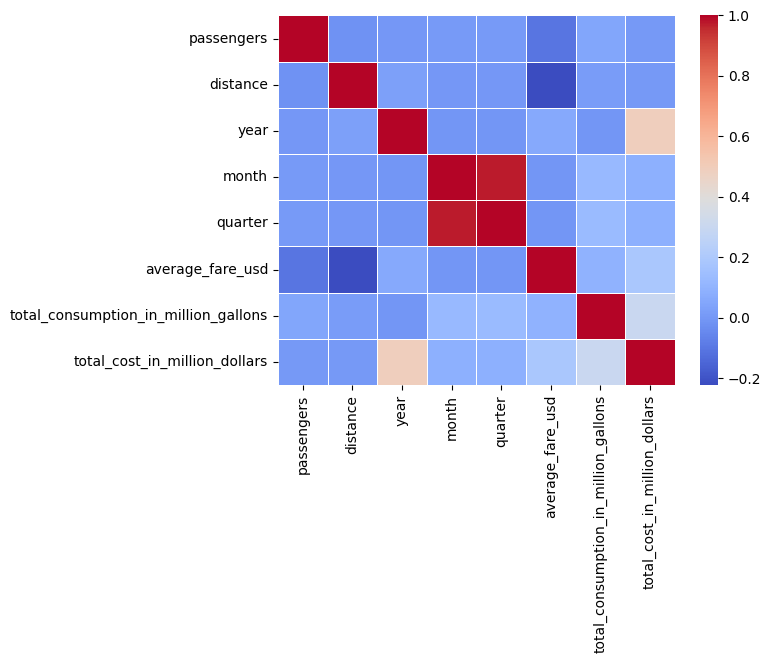

In [9]:
sns.heatmap(corr,
    cmap='coolwarm',
    center=None,
    robust=False,
    fmt='.2g',
    linewidths=0.5,
    linecolor='white')

In [10]:
df.rename(columns={
    'originstate': 'origin_state',
    'dest_city_name': 'destination_city_name',
    'deststate': 'destination_state'}, inplace=True)

In [11]:
df.columns.tolist()

['passengers',
 'distance',
 'airline_name',
 'airline_code',
 'carrierregion',
 'origin_airport_name',
 'origin_airport_code',
 'origin_city_name',
 'origin_state',
 'destination_airport_name',
 'destination_airport_code',
 'destination_city_name',
 'destination_state',
 'distancegroup',
 'serviceclass',
 'year',
 'month',
 'quarter',
 'average_fare_usd',
 'total_consumption_in_million_gallons',
 'total_cost_in_million_dollars']

In [14]:
# Step 1: Create the new 'route' column
df['route'] = df['origin_airport_name'] + " - " + df['destination_airport_name']

# Step 2: Reorder columns so 'route' is between 'destination_state' and 'distancegroup'
cols = df.columns.tolist()

# Find index of 'destination_state'
idx = cols.index('destination_state')

# Insert 'route' right after 'destination_state'
cols.insert(idx + 1, cols.pop(cols.index('route')))

# Reorder DataFrame
df = df[cols]

# Check result
print(df.columns.tolist())


['passengers', 'distance', 'airline_name', 'airline_code', 'carrierregion', 'origin_airport_name', 'origin_airport_code', 'origin_city_name', 'origin_state', 'destination_airport_name', 'destination_airport_code', 'destination_city_name', 'destination_state', 'route', 'distancegroup', 'serviceclass', 'year', 'month', 'quarter', 'average_fare_usd', 'total_consumption_in_million_gallons', 'total_cost_in_million_dollars']


In [12]:
categorical_features = [
    'origin_airport_name',  'origin_state', 'origin_city_name',
    'destination_airport_name', 'destination_state', 'destination_city_name',
    'distancegroup']

numerical_features = [
    'year', 'month', 'distance', 
    'total_cost_in_million_dollars', 
    'total_consumption_in_million_gallons']

target = 'average_fare_usd'

X = df[categorical_features + numerical_features]
y = df[target]

### 4. Split data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 6. Train LightGBM Model 

In [18]:
# Convert categorical features to pandas 'category' dtype
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("✅ Converted categorical columns to category dtype.")

# 4️⃣ Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data  = lgb.Dataset(X_test, label=y_test, reference=train_data)


params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

print("🚀 Training LightGBM directly on categorical data...")

model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    callbacks=[
        log_evaluation(period=50),
        early_stopping(stopping_rounds=50)
    ]
)

print("✅ Training complete!")


✅ Converted categorical columns to category dtype.
🚀 Training LightGBM directly on categorical data...
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1910.91
[100]	valid_0's l2: 1404.87
[150]	valid_0's l2: 1224.73
[200]	valid_0's l2: 1126.43
[250]	valid_0's l2: 1061.82
[300]	valid_0's l2: 1016.26
[350]	valid_0's l2: 982.832
[400]	valid_0's l2: 958.19
[450]	valid_0's l2: 939.062
[500]	valid_0's l2: 919.949
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 919.949
✅ Training complete!


### 7. Evaluate Model

In [19]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📈 Model Performance:")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"R² Score: {r2:.3f}")



📈 Model Performance:
Mean Absolute Error: $13.20
R² Score: 0.907


### 7. Save the trained model

In [20]:
joblib.dump(model, "lightgbm_fare_predictor.pkl")
print("✅ Model saved as lightgbm_fare_predictor.pkl")

✅ Model saved as lightgbm_fare_predictor.pkl


### 8. Load the trained model

In [7]:
model = joblib.load("lightgbm_fare_predictor.pkl")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


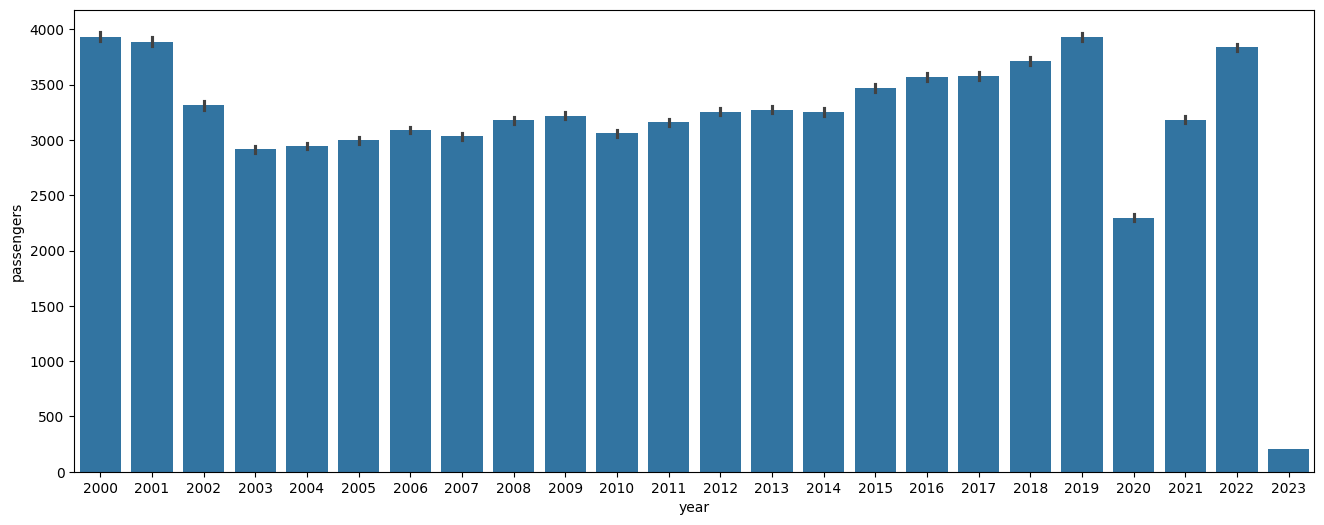

In [22]:
plt.figure(figsize=(16,6))
sns.barplot(x = df['year'],  y = df['passengers'], data = df)
plt.show()

In [23]:
# 🔹 Predict fares for the entire dataset
X_all = df[categorical_features + numerical_features]

# Ensure categorical columns are the right type
for col in categorical_features:
    X_all[col] = X_all[col].astype("category")

# 🔹 Generate predictions
df["predicted_fare_usd"] = model.predict(X_all, num_iteration=model.best_iteration)
df["predicted_fare_usd"] = df["predicted_fare_usd"].round(2)

print("✅ Added predicted_fare_usd column to the dataset!")

# 🔹 (Optional) Save to CSV for Power BI
#df.to_csv("flight_data_with_predictions.csv", index=False)
#print("💾 Saved file: flight_data_with_predictions.csv")


C:\Users\deves\AppData\Local\Temp\ipykernel_13560\4087368439.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all[col] = X_all[col].astype("category")
C:\Users\deves\AppData\Local\Temp\ipykernel_13560\4087368439.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all[col] = X_all[col].astype("category")
C:\Users\deves\AppData\Local\Temp\ipykernel_13560\4087368439.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

✅ Added predicted_fare_usd column to the dataset!


In [24]:
df.head()

,passengers,distance,airline_name,airline_code,carrierregion,origin_airport_name,origin_airport_code,origin_city_name,origin_state,destination_airport_name,destination_airport_code,destination_city_name,destination_state,distancegroup,serviceclass,year,month,quarter,average_fare_usd,total_consumption_in_million_gallons,total_cost_in_million_dollars,predicted_fare_usd
0,193,330,Great Lakes Airlines,ZK,Domestic,Worland Municipal,WRL,Worland,Wyoming,Denver International,DEN,Denver,Colorado,Less Than 500 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,598.000000,1282.5,4097.7,601.77
1,212,82,Alaska Airlines Inc.,AS,Domestic,Wrangell Airport,WRG,Wrangell,Alaska,Ketchikan International,KTN,Ketchikan,Alaska,Less Than 500 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,429.207692,1282.5,4097.7,436.39
2,190,756,Alaska Airlines Inc.,AS,Domestic,Wrangell Airport,WRG,Wrangell,Alaska,Seattle/Tacoma International,SEA,Seattle,Washington,500-999 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,429.207692,1282.5,4097.7,431.85
3,127,1092,Alaska Airlines Inc.,AS,Domestic,Yakutat Airport,YAK,Yakutat,Alaska,Seattle/Tacoma International,SEA,Seattle,Washington,1000-1499 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,359.164179,1282.5,4097.7,361.29
4,11,213,Alaska Airlines Inc.,AS,Domestic,Yakutat Airport,YAK,Yakutat,Alaska,Merle K Mudhole Smith,CDV,Cordova,Alaska,Less Than 500 Miles,Scheduled Passenger/ Cargo Service F,2011,4,2,359.164179,1282.5,4097.7,367.29


In [25]:
df.shape

(3020205, 22)

In [26]:
df.to_csv(r"D:\T-100 REFRENCE\QUERY\Project Files\tmff_predicted.csv", index=False)
print("💾 Saved file: flight_data_with_predictions.csv")


💾 Saved file: flight_data_with_predictions.csv


In [13]:
df.columns

Index(['passengers', 'distance', 'airline_name', 'airline_code',
       'carrierregion', 'origin_airport_name', 'origin_airport_code',
       'origin_city_name', 'origin_state', 'destination_airport_name',
       'destination_airport_code', 'destination_city_name',
       'destination_state', 'distancegroup', 'serviceclass', 'year', 'month',
       'quarter', 'average_fare_usd', 'total_consumption_in_million_gallons',
       'total_cost_in_million_dollars'],
      dtype='object')

In [18]:
# import numpy as np
# import pandas as pd

# --- 1️⃣ Pick top 10 busiest routes ---
top_routes = (
    df.groupby(['origin_airport_name', 'destination_airport_name'])['passengers']
      .sum()
      .nlargest(10)
      .reset_index()
)
print("✅ Top 10 routes selected:")
print(top_routes)

# --- 2️⃣ Define synthetic pricing parameters ---
price_change = np.linspace(0.8, 1.2, 9)          # ±20% price change
competitor_price = np.linspace(300, 450, 9)      # competitor price range

scenarios = []

# --- 3️⃣ Loop through each top route and generate scenarios ---
for _, route in top_routes.iterrows():
    base = {
        'origin_airport_name': route['origin_airport_name'],
        'destination_airport_name': route['destination_airport_name'],
    }

    # Retrieve representative values for this route
    route_data = df[
        (df['origin_airport_name'] == route['origin_airport_name']) &
        (df['destination_airport_name'] == route['destination_airport_name'])
    ].iloc[0]  # take one example row

    # Copy over additional context
    base.update({
        'origin_city_name': route_data['origin_city_name'],
        'origin_state': route_data['origin_state'],
        'destination_city_name': route_data['destination_city_name'],
        'destination_state': route_data['destination_state'],
        'distancegroup': route_data['distancegroup'],
        'distance': route_data['distance'],
        'year': 2024,
        'month': 6,
        'total_cost_in_million_dollars': route_data['total_cost_in_million_dollars'],
        'total_consumption_in_million_gallons': route_data['total_consumption_in_million_gallons']
    })

    # --- Generate synthetic scenarios ---
    for p_mult in price_change:
        for comp in competitor_price:
            row = base.copy()
            row['price_multiplier'] = round(p_mult, 2)
            row['competitor_fare'] = round(comp, 2)

            # Predict fare for this base route
            X_input = pd.DataFrame([base])
            for col in categorical_features:
                if col in X_input.columns:
                    X_input[col] = X_input[col].astype("category")

            row['predicted_fare_usd'] = model.predict(X_input, num_iteration=model.best_iteration)[0] * p_mult

            # Simple elasticity: higher price → lower demand
            row['sim_demand'] = max(0.1, 1.3 - p_mult)
            # Revenue = fare × demand
            row['sim_revenue'] = row['predicted_fare_usd'] * row['sim_demand']

            scenarios.append(row)

# --- 4️⃣ Combine into one dataframe ---
sim_df = pd.DataFrame(scenarios)

# --- 5️⃣ Save for Power BI ---
sim_df.to_csv("simulated_elasticity_top10_routes.csv", index=False)
print("✅ Saved: simulated_elasticity_top10_routes.csv")
print(f"Generated rows: {len(sim_df)}")


✅ Top 10 routes selected:
                        origin_airport_name  \
0  Hartsfield-Jackson Atlanta International   
1                     Orlando International   
2  Hartsfield-Jackson Atlanta International   
3   Fort Lauderdale-Hollywood International   
4          Phoenix Sky Harbor International   
5                           Kahului Airport   
6          Phoenix Sky Harbor International   
7             Daniel K Inouye International   
8          Phoenix Sky Harbor International   
9          Phoenix Sky Harbor International   

                   destination_airport_name  passengers  
0                     Orlando International    29710278  
1  Hartsfield-Jackson Atlanta International    29477318  
2   Fort Lauderdale-Hollywood International    25095142  
3  Hartsfield-Jackson Atlanta International    25074000  
4                 Los Angeles International    24460088  
5             Daniel K Inouye International    24445640  
6                  Harry Reid International    243

In [23]:
import numpy as np
import pandas as pd

# --- Identify top 10 routes by frequency ---
df["route"] = df["origin_airport_name"] + " → " + df["destination_airport_name"]
top_routes = df["route"].value_counts().head(100).index.tolist()
#top_routes = df["route"].value_counts().head(100).index.tolist()  # or 50 if you prefer


# --- Scenario parameters ---
price_change = np.linspace(0.8, 1.2, 9)   # simulate ±20 % price swings
competitor_price = np.linspace(300, 450, 9)

scenarios = []

for route_name in top_routes:
    # Extract route components
    origin_airport, destination_airport = route_name.split(" → ")

    route_df = df[
        (df["origin_airport_name"] == origin_airport) &
        (df["destination_airport_name"] == destination_airport)
    ]

    if route_df.empty:
        print(f"⚠️ No data for {route_name}, skipping.")
        continue

    route_row = route_df.iloc[0]

    # --- Build base row for this route ---
    base = {
        "origin_airport_name": route_row["origin_airport_name"],
        "origin_city_name": route_row["origin_city_name"],
        "origin_state": route_row["origin_state"],
        "destination_airport_name": route_row["destination_airport_name"],
        "destination_city_name": route_row["destination_city_name"],
        "destination_state": route_row["destination_state"],
        "distancegroup": route_row["distancegroup"],
        "distance": route_row["distance"],
        "year": 2024,
        "month": 6,
        "total_cost_in_million_dollars": route_row["total_cost_in_million_dollars"],
        "total_consumption_in_million_gallons": route_row["total_consumption_in_million_gallons"]
    }

    # --- Predict base fare once ---
    X_input = pd.DataFrame([base])
    for col in categorical_features:
        if col in X_input.columns:
            X_input[col] = X_input[col].astype("category")

    base_pred_fare = model.predict(X_input, num_iteration=model.best_iteration)[0]

    # --- Generate price–demand–revenue scenarios ---
    for p_mult in price_change:
        for comp in competitor_price:
            row = base.copy()
            row["route"] = route_name
            row["price_multiplier"] = round(p_mult, 2)
            row["competitor_fare"] = comp
            row["predicted_fare_usd"] = base_pred_fare * p_mult

            # Synthetic elasticity model (simple downward slope)
            row["sim_demand"] = max(0.1, 1.3 - p_mult)
            row["sim_revenue"] = row["predicted_fare_usd"] * row["sim_demand"]

            scenarios.append(row)

# --- Combine all routes into one DataFrame ---
sim_df = pd.DataFrame(scenarios)
sim_df["predicted_fare_usd"] = sim_df["predicted_fare_usd"].round(2)
sim_df["sim_revenue"] = sim_df["sim_revenue"].round(2)

# --- Save for Power BI ---
sim_df.to_csv("simulated_elasticity_top10_routes.csv", index=False)
print(f"✅ Saved {len(sim_df):,} simulated rows for top 10 routes → simulated_elasticity_top10_routes.csv")


✅ Saved 8,100 simulated rows for top 10 routes → simulated_elasticity_top10_routes.csv


In [24]:
import numpy as np
import pandas as pd

# --- 1️⃣ Identify all unique routes ---
df["route"] = df["origin_airport_name"] + " → " + df["destination_airport_name"] mnm 

unique_routes = df[["origin_airport_name", "destination_airport_name"]].drop_duplicates().reset_index(drop=True)

print(f"Found {len(unique_routes):,} unique routes to simulate.")

# --- 2️⃣ Setup price elasticity simulation parameters ---
price_change = np.linspace(0.8, 1.2, 9)   # simulate ±20 % fare swing
competitor_price = np.linspace(300, 450, 9)

scenarios = []

# --- 3️⃣ Loop through all unique routes ---
for idx, route in unique_routes.iterrows():
    origin_airport = route["origin_airport_name"]
    destination_airport = route["destination_airport_name"]

    # Find a reference row for this route
    route_df = df[
        (df["origin_airport_name"] == origin_airport) &
        (df["destination_airport_name"] == destination_airport)
    ]

    if route_df.empty:
        continue

    base_row = route_df.iloc[0]

    # --- Build base structure ---
    base = {
        "origin_airport_name": base_row["origin_airport_name"],
        "origin_city_name": base_row["origin_city_name"],
        "origin_state": base_row["origin_state"],
        "destination_airport_name": base_row["destination_airport_name"],
        "destination_city_name": base_row["destination_city_name"],
        "destination_state": base_row["destination_state"],
        "distancegroup": base_row["distancegroup"],
        "distance": base_row["distance"],
        "year": 2024,
        "month": 6,
        "total_cost_in_million_dollars": base_row["total_cost_in_million_dollars"],
        "total_consumption_in_million_gallons": base_row["total_consumption_in_million_gallons"]
    }

    # Prepare for prediction
    X_input = pd.DataFrame([base])
    for col in categorical_features:
        if col in X_input.columns:
            X_input[col] = X_input[col].astype("category")

    base_pred_fare = model.predict(X_input, num_iteration=model.best_iteration)[0]

    # --- Generate price–demand–revenue scenarios ---
    for p_mult in price_change:
        for comp in competitor_price:
            row = base.copy()
            row["route"] = f"{origin_airport} → {destination_airport}"
            row["price_multiplier"] = round(p_mult, 2)
            row["competitor_fare"] = comp
            row["predicted_fare_usd"] = base_pred_fare * p_mult
            row["sim_demand"] = max(0.1, 1.3 - p_mult)
            row["sim_revenue"] = row["predicted_fare_usd"] * row["sim_demand"]
            scenarios.append(row)

    # Optional: progress indicator every 500 routes
    if (idx + 1) % 500 == 0:
        print(f"Processed {idx + 1:,} routes...")

# --- 4️⃣ Combine and Save ---
sim_df = pd.DataFrame(scenarios)
sim_df["predicted_fare_usd"] = sim_df["predicted_fare_usd"].round(2)
sim_df["sim_revenue"] = sim_df["sim_revenue"].round(2)

file_name = "simulated_elasticity_all_routes.csv"
sim_df.to_csv(file_name, index=False)
print(f"✅ Done! Saved {len(sim_df):,} rows to {file_name}")


Found 37,194 unique routes to simulate.
Processed 500 routes...
Processed 1,000 routes...
Processed 1,500 routes...
Processed 2,000 routes...
Processed 2,500 routes...
Processed 3,000 routes...
Processed 3,500 routes...
Processed 4,000 routes...
Processed 4,500 routes...
Processed 5,000 routes...
Processed 5,500 routes...
Processed 6,000 routes...
Processed 6,500 routes...
Processed 7,000 routes...
Processed 7,500 routes...
Processed 8,000 routes...
Processed 8,500 routes...
Processed 9,000 routes...
Processed 9,500 routes...
Processed 10,000 routes...
Processed 10,500 routes...
Processed 11,000 routes...
Processed 11,500 routes...
Processed 12,000 routes...
Processed 12,500 routes...
Processed 13,000 routes...
Processed 13,500 routes...
Processed 14,000 routes...
Processed 14,500 routes...
Processed 15,000 routes...
Processed 15,500 routes...
Processed 16,000 routes...
Processed 16,500 routes...
Processed 17,000 routes...
Processed 17,500 routes...
Processed 18,000 routes...
Processed

In [26]:
df = pd.read_csv(r'C:\Users\deves\FLIGHT\T-100\simulated_elasticity_all_routes.csv')

In [10]:
#import numpy as np
#import pandas as pd

# --- 1️⃣ Add route column if not already there ---
df["route"] = df["origin_airport_name"] + " → " + df["destination_airport_name"]
unique_routes = df[["origin_airport_name", "destination_airport_name"]].drop_duplicates().reset_index(drop=True)

print(f"Found {len(unique_routes):,} unique routes to simulate.")

# --- 2️⃣ Simulation parameters ---
price_change = np.linspace(0.8, 1.2, 9)   # ±20% fare range
competitor_price = np.linspace(300, 450, 9)
scenarios = []

# --- 3️⃣ Loop through routes ---
for idx, route in unique_routes.iterrows():
    origin_airport = route["origin_airport_name"]
    destination_airport = route["destination_airport_name"]

    # Match row
    route_df = df[
        (df["origin_airport_name"] == origin_airport) &
        (df["destination_airport_name"] == destination_airport)
    ]
    if route_df.empty:
        continue

    base_row = route_df.iloc[0]

    # --- Include airline info here ---
    base = {
        "airline_name": base_row["airline_name"],
        "airline_code": base_row["airline_code"],
        "origin_airport_name": base_row["origin_airport_name"],
        "origin_city_name": base_row["origin_city_name"],
        "origin_state": base_row["origin_state"],
        "destination_airport_name": base_row["destination_airport_name"],
        "destination_city_name": base_row["destination_city_name"],
        "destination_state": base_row["destination_state"],
        "distancegroup": base_row["distancegroup"],
        "distance": base_row["distance"],
        "year": 2024,
        "month": 6,
        "total_cost_in_million_dollars": base_row["total_cost_in_million_dollars"],
        "total_consumption_in_million_gallons": base_row["total_consumption_in_million_gallons"]
    }

    X_input = pd.DataFrame([base])
    for col in ["airline_name", "airline_code"]:
        if col in X_input.columns:
            X_input = X_input.drop(columns=[col])
            
    for col in categorical_features:
        if col in X_input.columns:
            X_input[col] = X_input[col].astype("category")


    # ✅ Now predict
    base_pred_fare = model.predict(X_input, num_iteration=model.best_iteration)[0]

    # --- Generate scenarios ---
    for p_mult in price_change:
        for comp in competitor_price:
            row = base.copy()
            row["route"] = f"{origin_airport} → {destination_airport}"
            row["price_multiplier"] = round(p_mult, 2)
            row["competitor_fare"] = comp
            row["predicted_fare_usd"] = base_pred_fare * p_mult
            row["sim_demand"] = max(0.1, 1.3 - p_mult)
            row["sim_revenue"] = row["predicted_fare_usd"] * row["sim_demand"]
            scenarios.append(row)

    if (idx + 1) % 500 == 0:
        print(f"Processed {idx + 1:,} routes...")

# --- 4️⃣ Combine and save ---
sim_df = pd.DataFrame(scenarios)
sim_df["predicted_fare_usd"] = sim_df["predicted_fare_usd"].round(2)
sim_df["sim_revenue"] = sim_df["sim_revenue"].round(2)

file_name = "simulated_elasticity_all_routes_with_airlines.csv"
sim_df.to_csv(file_name, index=False)
print(f"✅ Done! Saved {len(sim_df):,} rows to {file_name}")


Found 37,194 unique routes to simulate.
Processed 500 routes...
Processed 1,000 routes...
Processed 1,500 routes...
Processed 2,000 routes...
Processed 2,500 routes...
Processed 3,000 routes...
Processed 3,500 routes...
Processed 4,000 routes...
Processed 4,500 routes...
Processed 5,000 routes...
Processed 5,500 routes...
Processed 6,000 routes...
Processed 6,500 routes...
Processed 7,000 routes...
Processed 7,500 routes...
Processed 8,000 routes...
Processed 8,500 routes...
Processed 9,000 routes...
Processed 9,500 routes...
Processed 10,000 routes...
Processed 10,500 routes...
Processed 11,000 routes...
Processed 11,500 routes...
Processed 12,000 routes...
Processed 12,500 routes...
Processed 13,000 routes...
Processed 13,500 routes...
Processed 14,000 routes...
Processed 14,500 routes...
Processed 15,000 routes...
Processed 15,500 routes...
Processed 16,000 routes...
Processed 16,500 routes...
Processed 17,000 routes...
Processed 17,500 routes...
Processed 18,000 routes...
Processed

In [11]:
df = pd.read_csv("simulated_elasticity_all_routes_with_airlines.csv")

In [12]:
df.shape

(3012714, 20)

In [13]:
df.isnull().sum()

airline_name                            0
airline_code                            0
origin_airport_name                     0
origin_city_name                        0
origin_state                            0
destination_airport_name                0
destination_city_name                   0
destination_state                       0
distancegroup                           0
distance                                0
year                                    0
month                                   0
total_cost_in_million_dollars           0
total_consumption_in_million_gallons    0
route                                   0
price_multiplier                        0
competitor_fare                         0
predicted_fare_usd                      0
sim_demand                              0
sim_revenue                             0
dtype: int64

In [14]:
df.duplicated().sum()

np.int64(0)

In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- PARAMETERS (tune if needed) ---
N_ROUTES = 200
TOP_AIRLINES_PER_ROUTE = 5
DAYS_BEFORE = 90   # simulate 90 -> 0 (inclusive)
SEAT_LEVELS = [150, 100, 50, 10]

# --- ASSUMPTIONS: df has these columns ---
# 'route', 'airline_name', 'predicted_fare_usd', 'passengers'
# fallback columns used if missing: 'average_fare_usd'
required_cols = ['route', 'airline_name', 'predicted_fare_usd', 'passengers']
for c in ['route', 'airline_name']:
    if c not in df.columns:
        raise RuntimeError(f"dataset missing required column: {c}")

# If predicted_fare_usd doesn't exist, fall back to average_fare_usd
if 'predicted_fare_usd' not in df.columns:
    if 'average_fare_usd' in df.columns:
        df['predicted_fare_usd'] = df['average_fare_usd']
    else:
        raise RuntimeError("No predicted_fare_usd or average_fare_usd found in df.")

# --- 1) pick top routes by total passengers ---
route_pop = df.groupby('route', dropna=True)['passengers'].sum().sort_values(ascending=False)
top_routes = route_pop.head(N_ROUTES).index.tolist()
print(f"Selected {len(top_routes)} routes (top by passengers).")

# --- 2) for each route pick top airlines by passengers on that route ---
route_airline_pairs = []
for route in top_routes:
    tmp = (
        df[df['route'] == route]
        .groupby('airline_name', dropna=True)['passengers']
        .sum()
        .sort_values(ascending=False)
        .head(TOP_AIRLINES_PER_ROUTE)
    )
    airlines = tmp.index.tolist()
    for a in airlines:
        route_airline_pairs.append((route, a))

route_airline_df = pd.DataFrame(route_airline_pairs, columns=['route', 'airline_name'])
print(f"Generated {len(route_airline_df)} route-airline pairs.")

# --- 3) prepare base stats per route-airline (mean predicted fare, mean passengers) ---
agg = (
    df.groupby(['route', 'airline_name'], dropna=True)
    .agg({
        'predicted_fare_usd': 'mean',
        'passengers': 'mean'
    })
    .rename(columns={'predicted_fare_usd': 'base_predicted_fare', 'passengers': 'base_passengers'})
    .reset_index()
)
# merge only for selected pairs
agg = agg.merge(route_airline_df, on=['route', 'airline_name'], how='right')

# fill missing base_predicted_fare with global median
agg['base_predicted_fare'] = agg['base_predicted_fare'].fillna(df['predicted_fare_usd'].median())
agg['base_passengers'] = agg['base_passengers'].fillna(df['passengers'].mean())

# normalize base_passengers to base_demand scale [0.1, 1.0]
min_p, max_p = agg['base_passengers'].min(), agg['base_passengers'].max()
if max_p == min_p:
    agg['base_demand_score'] = 0.5
else:
    agg['base_demand_score'] = 0.1 + 0.9 * ((agg['base_passengers'] - min_p) / (max_p - min_p))

# --- 4) Build simulation grid (vectorized) ---
rows = []
for _, row in tqdm(agg.iterrows(), total=len(agg), desc="Building scenarios"):
    route = row['route']
    airline = row['airline_name']
    base_price = float(row['base_predicted_fare'])
    base_demand_score = float(row['base_demand_score'])
    
    for seats in SEAT_LEVELS:
        # inventory pressure: 0 when full(150), up to 0.4 when nearly empty (10)
        inventory_pressure = 0.4 * (1 - (seats / 150.0))
        
        for days in range(DAYS_BEFORE, -1, -1):  # 90 down to 0
            # time pressure: 0 when far (90), up to 0.5 when last minute (0)
            time_pressure = 0.5 * (1 - (days / float(DAYS_BEFORE)))
            
            # combine pressures into a price adjustment factor
            combined_pressure = inventory_pressure * 0.6 + time_pressure * 0.4
            # final price = base_price * (1 + combined_pressure)
            final_price = base_price * (1.0 + combined_pressure)
            
            # demand model: baseline scaled by price change
            # if price increases relative to base -> demand falls; if price lower -> demand rises
            price_rel = final_price / base_price
            # elasticity factor (tunable) - higher => stronger demand change to price
            elasticity = 0.9
            demand_multiplier = max(0.05, 1.0 - elasticity * (price_rel - 1.0))
            sim_demand = base_demand_score * demand_multiplier
            
            sim_revenue = final_price * sim_demand
            
            rows.append({
                'route': route,
                'airline_name': airline,
                'base_predicted_fare': base_price,
                'days_before_departure': days,
                'seats_remaining': seats,
                'combined_pressure': round(combined_pressure, 4),
                'final_price': round(final_price, 2),
                'sim_demand': round(sim_demand, 4),
                'sim_revenue': round(sim_revenue, 2),
            })

sim_df = pd.DataFrame(rows)
print(f"Simulated rows: {len(sim_df):,}")

# --- 5) Add helpful identifying columns from original df (e.g., origin/destination) ---
# grab one representative row per route-airline from original df
rep = df[['route', 'airline_name', 'origin_airport_name', 'origin_city_name', 'origin_state',
          'destination_airport_name', 'destination_city_name', 'destination_state', 'distance']].drop_duplicates(subset=['route','airline_name'])
sim_df = sim_df.merge(rep, on=['route','airline_name'], how='left')

# --- 6) Save CSV for Power BI ---
out_file = "inventory_simulation_30_routes.csv"
sim_df.to_csv(out_file, index=False)
print(f"✅ Saved inventory simulation to: {out_file}")

Selected 200 routes (top by passengers).
Generated 999 route-airline pairs.


Building scenarios: 100%|███████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 466.85it/s]


Simulated rows: 363,636
✅ Saved inventory simulation to: inventory_simulation_30_routes.csv


In [18]:
d= pd.read_csv(r'C:\Users\deves\FLIGHT\T-100\inventory_simulation_30_routes.csv')
d.shape

(363636, 16)

In [ ]:
df['route'].nunique()

In [20]:
d.head()

,route,airline_name,base_predicted_fare,days_before_departure,seats_remaining,combined_pressure,final_price,sim_demand,sim_revenue,origin_airport_name,origin_city_name,origin_state,destination_airport_name,destination_city_name,destination_state,distance
0,Hartsfield-Jackson Atlanta International - Orl...,Delta Air Lines Inc.,346.910338,90,150,0.0000,346.91,1.000,346.91,Hartsfield-Jackson Atlanta International,Atlanta,Georgia,Orlando International,Orlando,Florida,404
1,Hartsfield-Jackson Atlanta International - Orl...,Delta Air Lines Inc.,346.910338,89,150,0.0022,347.68,0.998,346.99,Hartsfield-Jackson Atlanta International,Atlanta,Georgia,Orlando International,Orlando,Florida,404
2,Hartsfield-Jackson Atlanta International - Orl...,Delta Air Lines Inc.,346.910338,88,150,0.0044,348.45,0.996,347.06,Hartsfield-Jackson Atlanta International,Atlanta,Georgia,Orlando International,Orlando,Florida,404
3,Hartsfield-Jackson Atlanta International - Orl...,Delta Air Lines Inc.,346.910338,87,150,0.0067,349.22,0.994,347.13,Hartsfield-Jackson Atlanta International,Atlanta,Georgia,Orlando International,Orlando,Florida,404
4,Hartsfield-Jackson Atlanta International - Orl...,Delta Air Lines Inc.,346.910338,86,150,0.0089,349.99,0.992,347.19,Hartsfield-Jackson Atlanta International,Atlanta,Georgia,Orlando International,Orlando,Florida,404
